In [1]:
import pandas as pd
#import simplejson as json
import branca.colormap as cm
from scipy.stats import boxcox
import geopandas as gpd
import seaborn as sns
import datetime as dt
import numpy as np
#from mpl_toolkits.basemap import Basemap
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
from matplotlib.ticker import StrMethodFormatter
from pandas import DataFrame
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn')
import json
import glob
import re
import os
import io


%matplotlib inline

In [2]:
state_shp = '/Users/leo/Personal/Python/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'


In [3]:
Tn_accident= pd.read_csv("../data/Tn_Accidents.csv")
#Traffic_Accident=pd.read_csv('../data/Traffic_Accidents.csv')
traffic_accident=gpd.read_file('../data/Traffic Accidents.geojson')
zipcodes = gpd.read_file('../data/zipcodes.geojson')
country=gpd.read_file('../data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')

In [4]:
Tn_accident.shape

(17143, 47)

In [5]:
country.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."


# we gave two types of features in the data one is Catagorical and Numerical.

In [81]:
#select numerice feature from the dataframe
numeric_features=Tn_accident.select_dtypes(include=[np.number])
numeric_features.columns

Index(['Severity', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)',
       'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)',
       'Time_Diff', 'Year', 'Month', 'Day', 'Hour', 'Min'],
      dtype='object')

In [82]:
#select Categorical features from the dataframe
categorical_features=Tn_accident.select_dtypes(include=[np.object])
categorical_features.columns

Index(['ID', 'Description', 'Street', 'Side', 'City', 'County', 'Zipcode',
       'Timezone', 'Airport_Code', 'Wind_Direction', 'Weather_Condition',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight', 'Start_Date', 'End_Date'],
      dtype='object')

# Handling missing values
First of all, we will check which all labels have some null values.

In [7]:
missing=pd.DataFrame(Tn_accident.isnull().sum()).reset_index()
missing.columns = ['Labels', 'counts']
missing

,Labels,counts
0,ID,0
1,Severity,0
2,Start_Time,0
3,End_Time,0
4,Start_Lat,0
5,Start_Lng,0
6,End_Lat,0
7,End_Lng,0
8,Distance(mi),0
9,Description,0


In [8]:
# Exclude unnecessary columns

Tn_accident.drop(['End_Lng','End_Lat','State','Country','Number','Wind_Chill(F)','Precipitation(in)','Weather_Timestamp'], axis=1, inplace=True)

In [9]:
# Summary Statistics
Tn_accident.describe()

,Severity,Start_Lat,Start_Lng,Distance(mi),Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph)
count,17143.000000,17143.000000,17143.000000,17143.000000,16956.000000,16950.000000,17049.000000,17051.000000,16392.000000
mean,2.063991,35.774143,-86.538179,0.583028,60.088966,66.605310,29.536854,9.247402,6.840410
std,0.564827,0.507723,1.457101,1.142939,16.437936,20.423629,0.401853,2.037726,4.817695
min,1.000000,34.983183,-90.096510,0.000000,0.000000,14.000000,27.430000,0.000000,0.000000
25%,2.000000,35.123020,-86.791380,0.016000,48.000000,50.000000,29.330000,10.000000,3.000000
50%,2.000000,36.070250,-86.721020,0.145000,61.000000,70.000000,29.490000,10.000000,6.000000
75%,2.000000,36.156591,-85.293609,0.587000,73.000000,84.000000,29.700000,10.000000,9.200000
max,4.000000,36.628190,-82.103028,21.189000,98.100000,100.000000,57.740000,10.000000,34.500000


In [83]:
 #keep only the frist 5 digit 
Tn_accident['Zipcode']= Tn_accident  ['Zipcode'].str.extract('(\d\d\d\d\d)',expand=True)

# Value imputation
Since this is a huge dataset,I will be filling nan values with mean values.

In [10]:
# For numeric variables, I will be using mean values

Tn_accident['Pressure(in)'] =Tn_accident['Pressure(in)'].fillna(Tn_accident['Pressure(in)'].mean())
Tn_accident['Temperature(F)'] =Tn_accident['Temperature(F)'].fillna(Tn_accident['Temperature(F)'].mean())
Tn_accident['Humidity(%)'] = Tn_accident['Humidity(%)'].fillna(Tn_accident['Humidity(%)'].mean())
Tn_accident['Visibility(mi)'] = Tn_accident['Visibility(mi)'].fillna(Tn_accident['Visibility(mi)'].mean())
Tn_accident['Wind_Speed(mph)'] = Tn_accident['Wind_Speed(mph)'].fillna(Tn_accident['Wind_Speed(mph)'].mean())

In [11]:
Tn_accident.Severity.value_counts()

2    13947
1     1440
3      975
4      781
Name: Severity, dtype: int64

In [12]:
#rename zip by zipcode
traffic_accident.rename(columns={'zip':'Zipcode'}, inplace=True)

In [13]:
# change the data type to datetime.
Tn_accident.Start_Time.replace({'/0/' : '/1/'}, regex = True, inplace = True)


In [14]:
# change the data type to datetime.
Tn_accident['Start_Time']

0         11/30/16 5:07 PM
1         11/30/16 5:07 PM
2         11/30/16 5:41 PM
3         11/30/16 5:41 PM
4         11/30/16 6:05 PM
               ...        
17138     12/10/19 2:48 PM
17139     12/10/19 4:05 PM
17140     12/10/19 4:56 PM
17141    12/10/19 10:51 PM
17142    12/10/19 10:51 PM
Name: Start_Time, Length: 17143, dtype: object

In [15]:
Tn_accident['Start_Time']=pd.to_datetime(Tn_accident['Start_Time'],format='%m/%d/%y %H:%M %p')

In [16]:

Tn_accident.End_Time.replace({'/0/' : '/1/'}, regex = True, inplace = True)

In [17]:
Tn_accident['End_Time']=pd.to_datetime(Tn_accident['End_Time'],format='%m/%d/%y %H:%M %p')


In [18]:

Tn_accident['Start_Date'] = Tn_accident['Start_Time'].dt.date
Tn_accident['End_Date'] =Tn_accident['End_Time'].dt.date
Tn_accident['Time_Diff'] = (Tn_accident.End_Time - Tn_accident.Start_Time)
Tn_accident['Year'] = Tn_accident['Start_Time'].dt.year
Tn_accident['Month'] =Tn_accident['Start_Time'].dt.month
Tn_accident['Day'] =Tn_accident['Start_Time'].dt.day
Tn_accident['Hour'] = Tn_accident['Start_Time'].dt.hour
Tn_accident['Min'] = Tn_accident['Start_Time'].dt.minute

In [19]:
#slice only from 2016-2021
Tn_accident1=Tn_accident[Tn_accident['Year'].between(2016,2021)]
Tn_accident1

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,Distance(mi),Description,Street,Side,...,Nautical_Twilight,Astronomical_Twilight,Start_Date,End_Date,Time_Diff,Year,Month,Day,Hour,Min
0,A-2749210,2,2016-11-30 05:07:00,2016-11-30 11:07:00,35.152571,-89.886753,0.383,At I-40/Exit 12 - Accident.,I-240 W,R,...,Day,Day,2016-11-30,2016-11-30,0 days 06:00:00,2016,11,30,5,7
1,A-2749215,2,2016-11-30 05:07:00,2016-11-30 11:07:00,35.153122,-89.887304,0.237,At I-240/Sam Cooper/Exit 10/Exit 12 - Accident.,I-40 E,R,...,Day,Day,2016-11-30,2016-11-30,0 days 06:00:00,2016,11,30,5,7
2,A-2749231,2,2016-11-30 05:41:00,2016-11-30 11:41:00,36.153730,-86.763210,0.131,At I-65/Exit 211 - Accident.,I-40 E,R,...,Night,Day,2016-11-30,2016-11-30,0 days 06:00:00,2016,11,30,5,41
3,A-2749232,2,2016-11-30 05:41:00,2016-11-30 11:41:00,36.154430,-86.761020,0.147,At I-65/Exit 211 - Accident.,I-40 E,R,...,Night,Day,2016-11-30,2016-11-30,0 days 06:00:00,2016,11,30,5,41
4,A-2749247,2,2016-11-30 06:05:00,2016-12-01 12:05:00,36.151520,-86.751530,0.053,At Fairfield Ave/Exit 212 - Accident.,I-24 W,R,...,Night,Night,2016-11-30,2016-12-01,1 days 06:00:00,2016,11,30,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17138,A-3770942,2,2019-12-10 02:48:00,2019-12-10 03:16:00,36.154090,-86.838000,0.579,At 46th Ave/Exit 205 - Accident.,I-40 W,R,...,Day,Day,2019-12-10,2019-12-10,0 days 00:28:00,2019,12,10,2,48
17139,A-3770944,2,2019-12-10 04:05:00,2019-12-10 04:35:00,36.149460,-86.783820,0.196,At I-65/Exit 210 - Accident. Lane blocked.,I-65 S,R,...,Day,Day,2019-12-10,2019-12-10,0 days 00:30:00,2019,12,10,4,5
17140,A-3770948,2,2019-12-10 04:56:00,2019-12-10 05:26:00,36.075210,-86.693230,0.479,At TN-255/Harding Pl/Exit 56 - Accident.,I-24 W,R,...,Day,Day,2019-12-10,2019-12-10,0 days 00:30:00,2019,12,10,4,56
17141,A-3770953,3,2019-12-10 10:51:00,2019-12-10 11:20:00,35.823320,-86.886490,0.158,At Tollgate Blvd - Multi-vehicle accident invo...,Columbia Pike,L,...,Night,Night,2019-12-10,2019-12-10,0 days 00:29:00,2019,12,10,10,51


In [20]:
hour_min=Tn_accident1[['Hour','Min']].head(10)
hour_min.sort_values(['Hour','Min'],ascending=False,inplace=True)


# Exploratory Data Analysis
Now we will check how much accidents happened in each year.

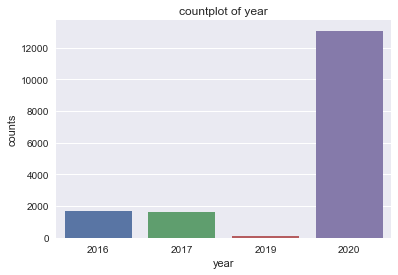

In [21]:
year_count=Tn_accident1['Year'].value_counts().reset_index().rename(columns={'index':'year','Year':'counts'})
x=year_count.year
y=year_count.counts
sns.barplot(x,y,data = year_count)
plt.title('countplot of year')



plt.show()

# Now we will check how much accidents (of each severity level) happened in each year.


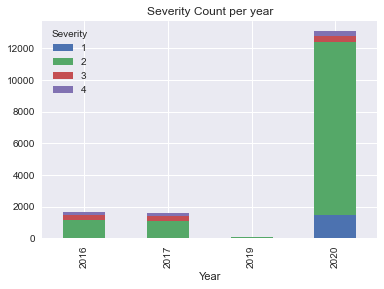

<Figure size 1440x576 with 0 Axes>

In [22]:
# plot bar graph for accidents per year
accidents =Tn_accident1.groupby(['Year', 'Severity']).size().reset_index().pivot(columns='Severity', 
                                                                      index='Year', values=0)

accidents.plot(kind='bar', stacked=True, title='Severity Count per year')
plt.figure(figsize=(20,8))


plt.show();

As we can see, most of the accidents happened in each year is of severity level 2 followed by severity level 3. And the plot shows that count of other severity level accidents are very low. This class imbalance represents either accidents of severity level 4 has happened very low or it has not been reported. Another thing worth noticing is that accident counts in 2016 and 2017 were the same lavel but suddeny dropped at a drastic level in 2019 which again shows either accidents reduced due to some rules and regulation being followed rigorously or low cases were reported by the source. But in any way, class is highly imbalanced.

In [23]:
Tn_accident.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'Description', 'Street', 'Side', 'City', 'County',
       'Zipcode', 'Timezone', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
       'Start_Date', 'End_Date', 'Time_Diff', 'Year', 'Month', 'Day', 'Hour',
       'Min'],
      dtype='object')

# Now we will check number of accidents haapening month-wise to check whether we can see any pattern in that


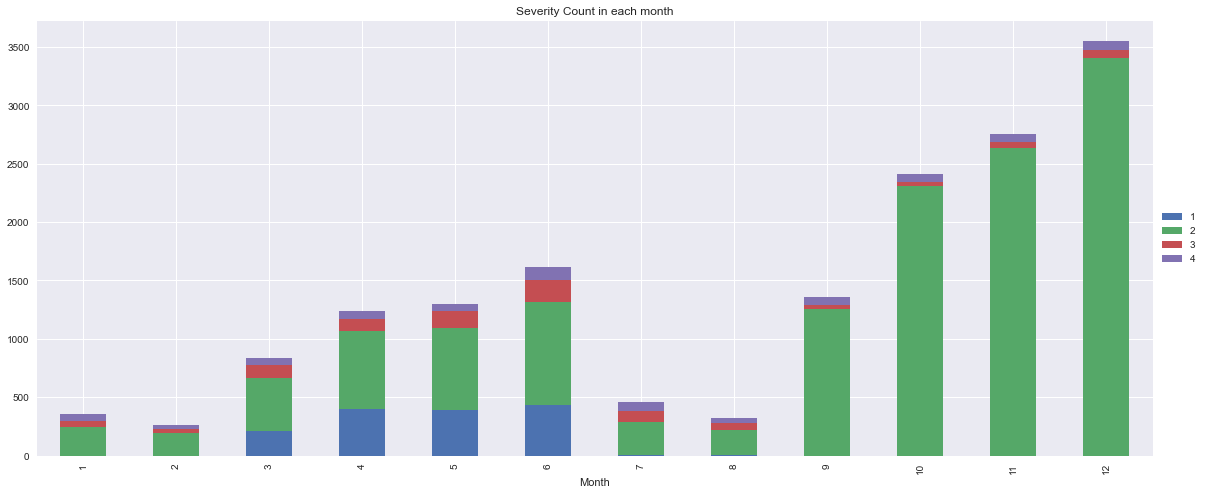

In [24]:
accidents =Tn_accident1.groupby([ 'Month', 'Severity']).size().reset_index().pivot(columns='Severity', 
                                                                      index='Month', values=0)

accidents.plot(kind='bar', stacked=True, figsize=(20,8), title='Severity Count in each month').legend(loc='center left',
                                                                                                      bbox_to_anchor=(1.0, 0.5))

All we can see is that most of the accidents happened in Aprile to June and then September to December. It is quite an interesting find and there may be some relation with the weather so we will check that out

# Now we will check the number of accidents based on the weather condition.
 

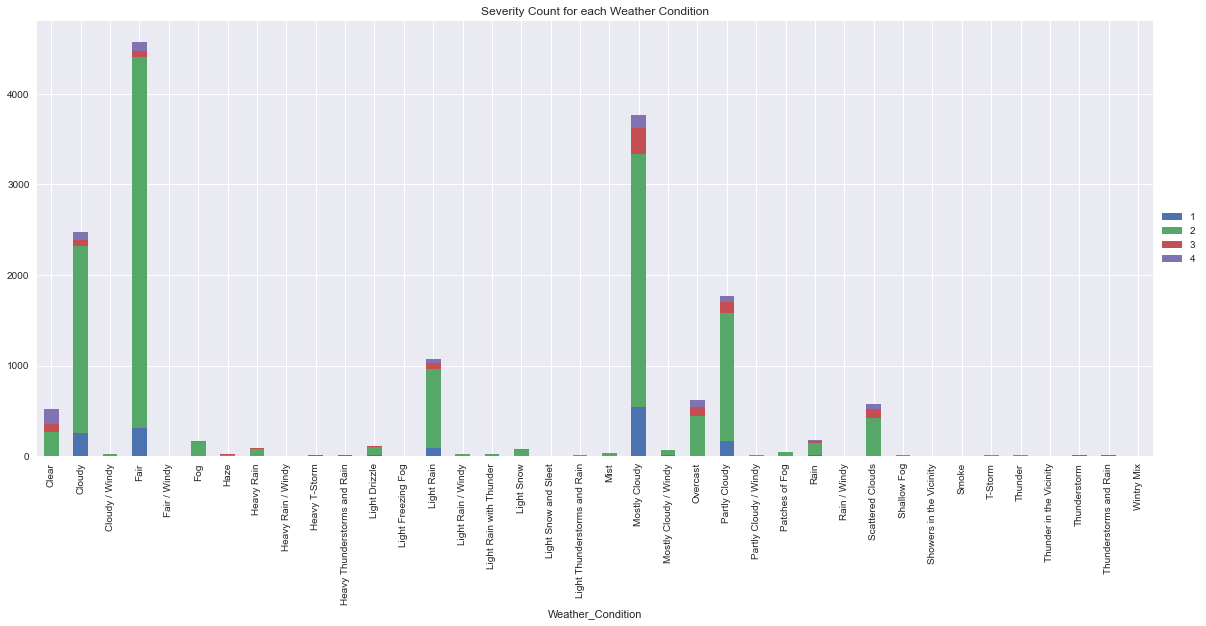

In [25]:
accidents =Tn_accident1.groupby(['Weather_Condition', 'Severity']).size().reset_index().pivot(columns='Severity', 
                                                                      index='Weather_Condition', values=0)

accidents.plot(kind='bar', stacked=True, figsize=(20,8), title='Severity Count for each Weather Condition').legend(loc='center left',
                                                                                        bbox_to_anchor=(1.0, 0.5))

here as most of the accidents have happened on clear days. But we will investigate for specifically severity level 4.

<AxesSubplot:xlabel='Weather_Condition'>

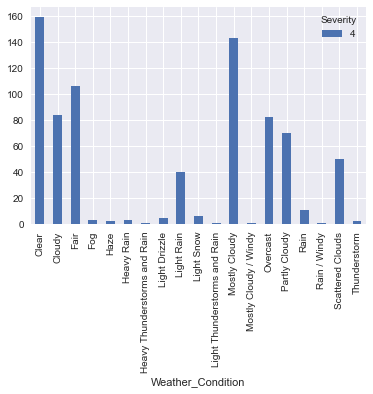

In [26]:
severe_4 = Tn_accident1[Tn_accident1.Severity == 4]
accidents = severe_4.groupby(['Weather_Condition', 'Severity']).size().reset_index().pivot(columns='Severity', 
                                                                      index='Weather_Condition', values=0)
accidents.plot(kind='bar')

Clearly there is no anomaly in this as most of the accidents happened on clear days. That may mean the accidents don't have any particular reason for happening mostly in October.

# Now we will check whether accidents are happening during day or night. For that, we will take 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight'and 'Astronomical_Twilight'.

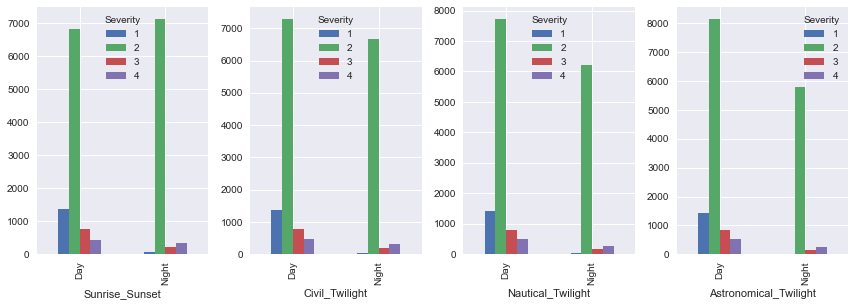

In [27]:
f = ['Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']
fig, axs = plt.subplots(ncols=4, figsize=(12, 4))
fig.tight_layout()
for i,feature in enumerate(f):
    accidents = Tn_accident.groupby([feature, 'Severity']).size().reset_index().pivot(columns=
                                                            'Severity', index=feature, values=0)
    accidents.plot(kind='bar', ax=axs[i])

We observe that most of the accidents happened during the day 

In [28]:
City_counts=Tn_accident1['City'].value_counts()

City_counts1=City_counts.reset_index().rename(columns={'index':'City','City':'counts'}).head(20)


In [29]:
#We can use groupby to organize the data by City and counts
City_counts1=City_counts1.groupby(['City','counts']).sum()
City_counts2=City_counts1.sort_values('counts',ascending=False,).reset_index()
City_counts2

,City,counts
0,Nashville,6587
1,Chattanooga,2767
2,Memphis,1516
3,Antioch,771
4,Knoxville,526
5,Madison,473
6,Hixson,299
7,Brentwood,253
8,Ooltewah,224
9,Hermitage,221


# We will check which City has the most number of accidents.

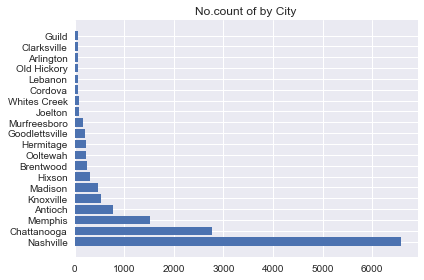

In [30]:
#make a plot using variable 

x=City_counts2.City
y=City_counts2.counts

plt.barh(x,y)
plt.title('No.count of by City' )
plt.tight_layout()
plt.show()

#City_counts1.plot(kind='barh')

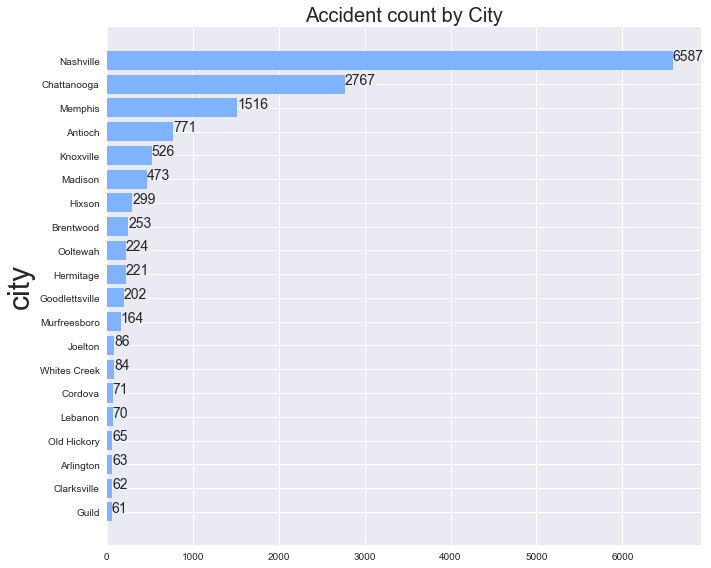

In [31]:

x=City_counts2.City
y=City_counts2.counts

plt.rcParams['figure.figsize'] = [10, 8]
plt.barh(x,y, color='#80B3FF')
for index, value in enumerate(y):
    plt.text(value, index, str(value),size=14)
plt.ylabel('city', size = 30)
plt.title('Accident count by City', size=20 )
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()

We see that Nashville, chattanooga and Memphis consists of majority of the accidents. Now, we will dig further deep and see which state has more severity level 4 accidents.

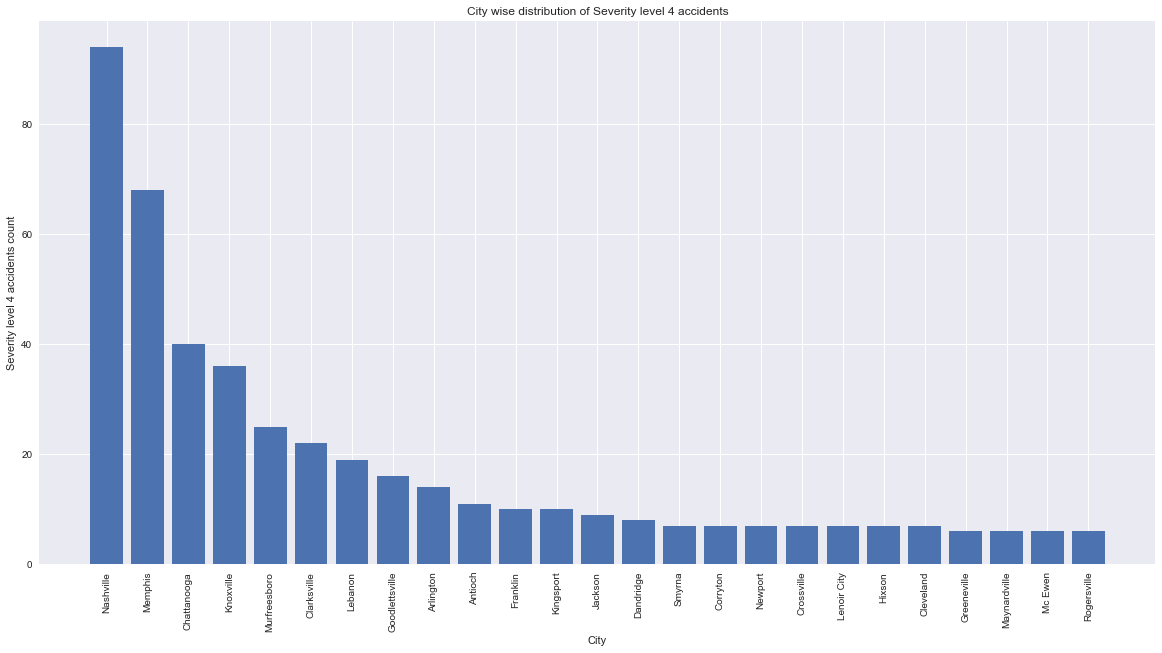

In [32]:
severe_4 = Tn_accident[Tn_accident.Severity == 4].City.value_counts().to_frame().reset_index().head(25)
severe_4.columns = ['City', 'Accidents']
severe_4 = severe_4.sort_values(by='Accidents', ascending=False)

lists = list(severe_4.City)
y_pos = np.arange(len(lists))
Numbers = list(severe_4.Accidents)
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
plt.bar(y_pos, Numbers, align='center', alpha=1)
plt.xticks(y_pos, lists, rotation=90)#rotation will xaxis label to be on 90 degree. 
plt.xlabel('City')
plt.ylabel('Severity level 4 accidents count')
plt.title('City wise distribution of Severity level 4 accidents')
plt.show()

So Tennessee and Memphis consists of majority of the accidents of Severity level 4.

Similiarly, we want to see in what time of the day, more accidents will happen using a heatmap.

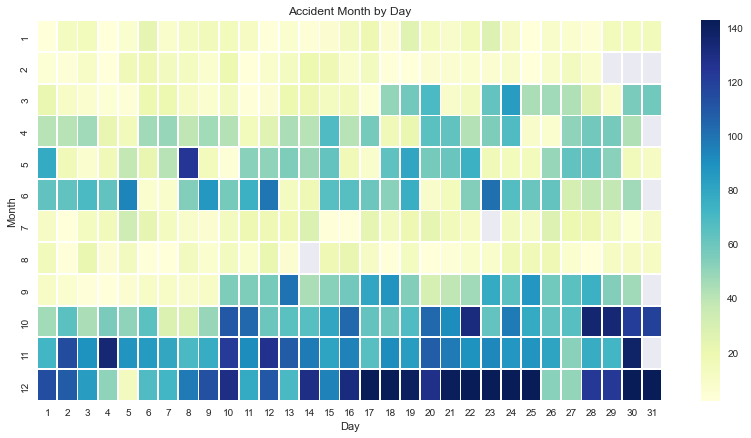

In [33]:
plt.figure(figsize=(14,7))
plt.title('Accident Month by Day')
month_day = Tn_accident1.groupby(['Month','Day']).size().unstack()
ax = sns.heatmap(month_day, cmap='YlGnBu',linewidths=0.8, robust=True)

Similiarly, we want to see in what time of the day, more accidents will happen using a heatmap.

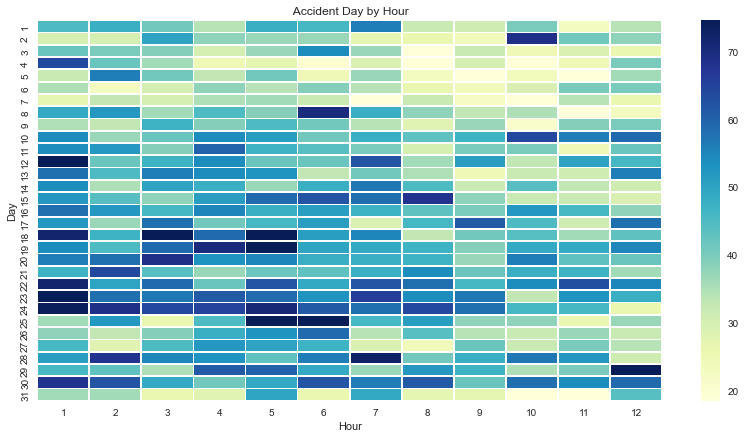

In [34]:
plt.figure(figsize=(14,7))
plt.title(' Accident Day by Hour')
month_day = Tn_accident1.groupby(['Day','Hour']).size().unstack()
ax = sns.heatmap(month_day, cmap='YlGnBu',linewidths=0.8, robust=True)

# Now let's plot the accidents on a map

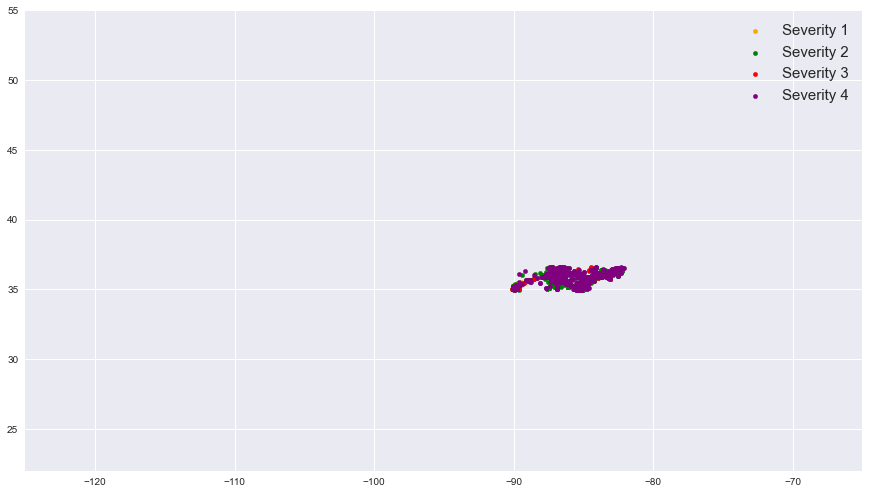

In [35]:
geometry = [Point(xy) for xy in zip(Tn_accident['Start_Lng'], Tn_accident['Start_Lat'])]
geo_df = gpd.GeoDataFrame(Tn_accident, geometry=geometry)



#us_mapy=gpd.read_file('../data/cb_2018_us_state_500k/cb_2018_us_state_500k.shp')
us_mapy = '/Users/leo/Personal/Python/cb_2018_us_state_500k/cb_2018_us_state_500k.shp'
fig, ax = plt.subplots(figsize=(15,15))
ax.set_xlim([-125,-65])
ax.set_ylim([22,55])
geo_df[geo_df['Severity'] == 1].plot(ax=ax, markersize=20, color='orange', marker='o', label='Severity 1')
geo_df[geo_df['Severity'] == 2].plot(ax=ax, markersize=20, color='green', marker='o', label='Severity 2')
geo_df[geo_df['Severity'] == 3].plot(ax=ax, markersize=20, color='red', marker='o', label='Severity 3')
geo_df[geo_df['Severity'] == 4].plot(ax=ax, markersize=20, color='purple', marker='o', label='Severity 4')
plt.legend(prop={'size': 15})

# We will see whether the numerical variables are normalized or not

Pressure(in)


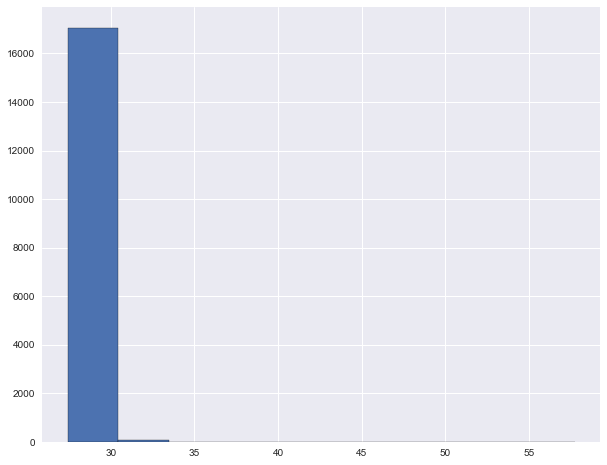

Temperature(F)


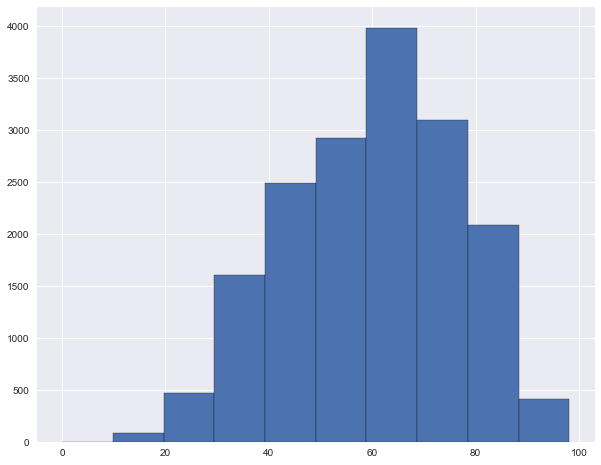

Humidity(%)


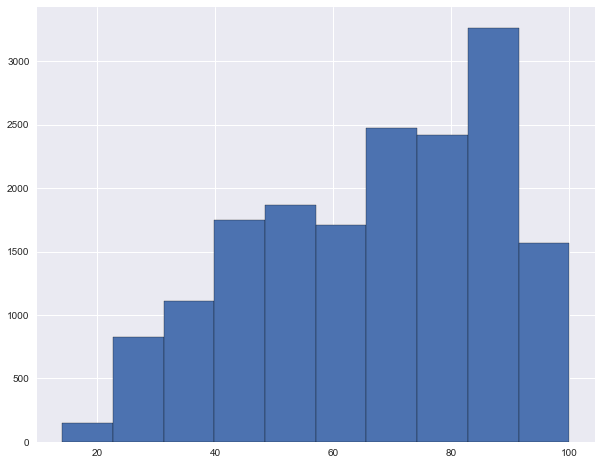

Visibility(mi)


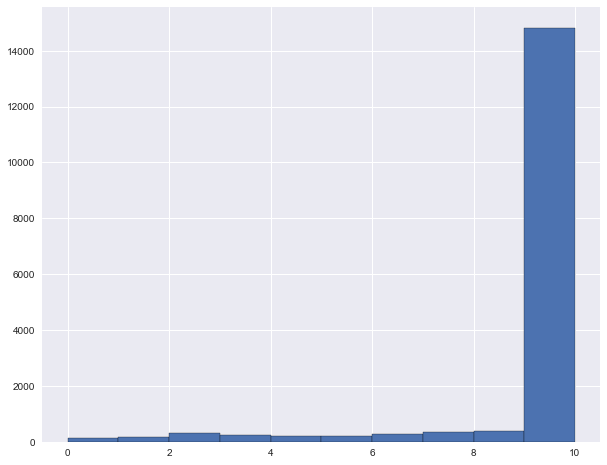

Wind_Speed(mph)


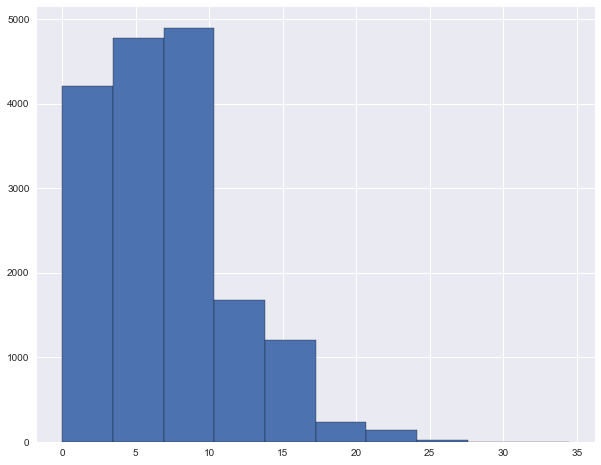

In [36]:
vars = ['Pressure(in)', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Speed(mph)']

for i in vars:
    print(i)
    plt.hist(Tn_accident[i],edgecolor='black')
    plt.show()

In [37]:
#group the city and apply agg function on cunts column
city_group=City_counts2.groupby(['City']).agg({'counts':['sum','max','mean']}).reset_index()
city_group

City counts              
                      sum   max    mean
0          Antioch    771   771   771.0
1        Arlington     63    63    63.0
2        Brentwood    253   253   253.0
3      Chattanooga   2767  2767  2767.0
4      Clarksville     62    62    62.0
5          Cordova     71    71    71.0
6   Goodlettsville    202   202   202.0
7            Guild     61    61    61.0
8        Hermitage    221   221   221.0
9           Hixson    299   299   299.0
10         Joelton     86    86    86.0
11       Knoxville    526   526   526.0
12         Lebanon     70    70    70.0
13         Madison    473   473   473.0
14         Memphis   1516  1516  1516.0
15    Murfreesboro    164   164   164.0
16       Nashville   6587  6587  6587.0
17     Old Hickory     65    65    65.0
18        Ooltewah    224   224   224.0
19    Whites Creek     84    84    84.0

In [38]:
#First group the data by year and Severity and use size() to count the records in each group, then use unstack() to pivot the result.
Tn_accident1.groupby(["Year","Severity"]).size().unstack().fillna(0)


Severity,1,2,3,4
Year,,,,
2016,0.0,1165.0,286.0,237.0
2017,0.0,1100.0,276.0,230.0
2019,0.0,57.0,10.0,16.0
2020,1440.0,10932.0,403.0,292.0


In [39]:
#First group the data by year and Severity and use size() to count the records in each group, 
#then use unstack() to pivot the result

year_grp = Tn_accident1.groupby(["Year"]).agg(Count = ('ID','count'))
year_sev =Tn_accident1.groupby(["Year","Severity"]).size().unstack()


# Severity

The purpose of this analysis is to analyze the data and find out what are the key variables that impact the severity of the traffic accidents that happened in Tennessee and ultimately predict the severity of the accidents based on given variables through data visulization

<function matplotlib.pyplot.show(close=None, block=None)>

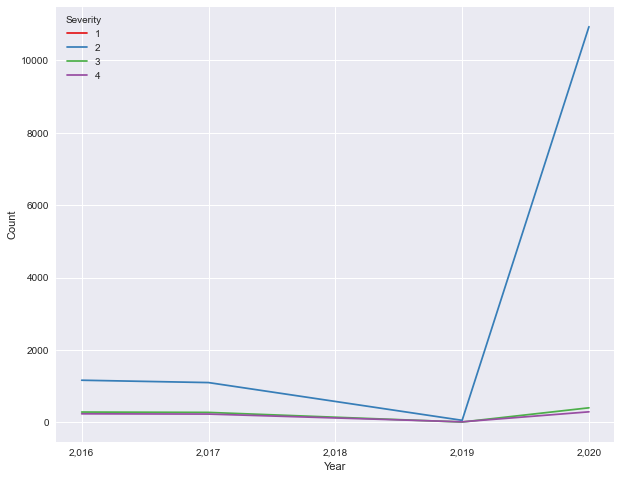

In [40]:
group_year_sev2 = Tn_accident1.groupby(["Year","Severity"]).agg(Count = ('ID','count')).reset_index()
sns.lineplot(x='Year',y='Count',hue="Severity",data=group_year_sev2,palette="Set1")
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.xticks(np.arange(2016, 2021, 1.0));
plt.show

In [41]:
#Tn_accident1.groupby(["Year","Severity"]).size().unstack().plot(kind='bar', stacked=True)

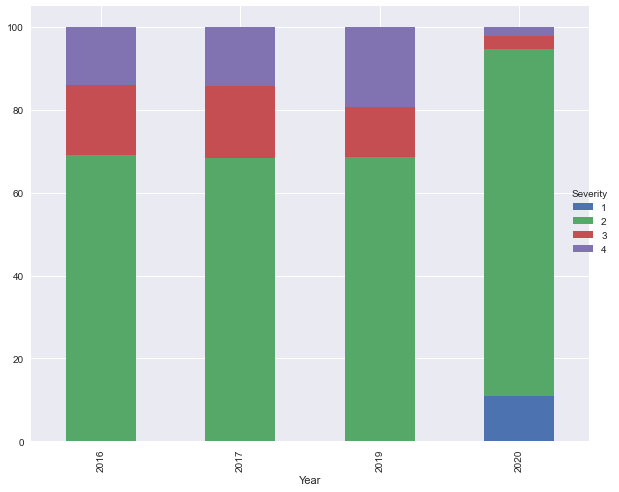

In [42]:
# Makes more sense to show stacked 100%, a different view
Tn_accident1.groupby(["Year","Severity"]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True)

plt.gca().yaxis
#plt.legend(loc = 'upper left',title = 'Severity')
plt.legend([1,2,3,4], title='Severity',
           bbox_to_anchor = (1.05, 0.6))
plt.show()

The dataset also contains some variables regarding the weather condition when the accidents happened. We also want to examine those variables to see if any of the weather related variables have impact on the severity of the accidents.

We want to use boxplot from seaborn library to see how the weather related variable changed in different type of accidents.

Below is a boxplot of Temperature and Severity, we can see that there are difference in median temparature in all severity while lower medium temperature in severity 2, which might indicate that lower temperature might result to severe accidents.

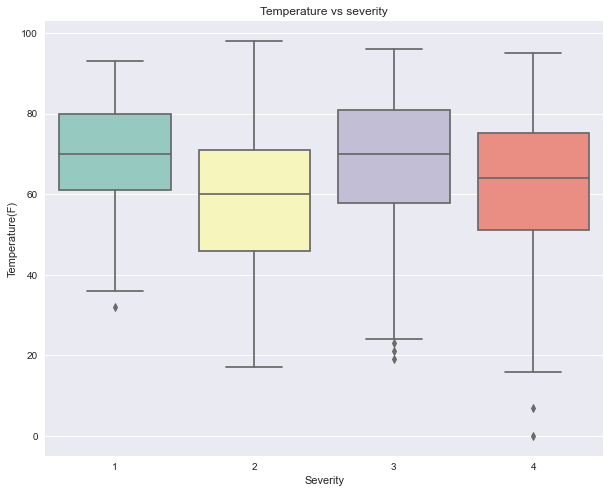

In [43]:
sns.boxplot(x="Severity", y="Temperature(F)", data=Tn_accident1, palette="Set3");
plt.title('Temperature vs severity');

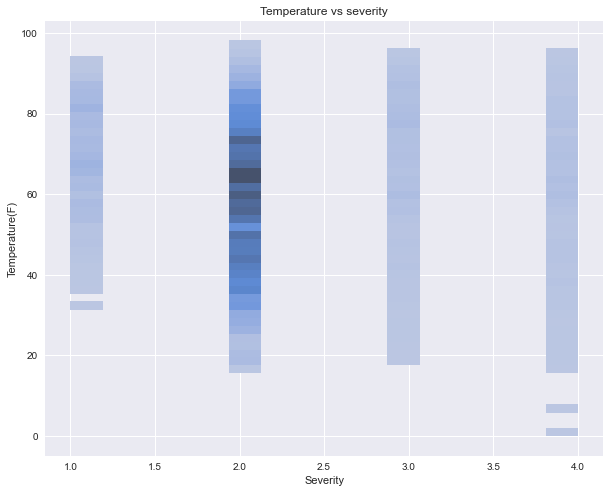

In [44]:
sns.histplot(x="Severity", y="Temperature(F)", data=Tn_accident1, palette="Set3");
plt.title('Temperature vs severity');

Below is a boxplot of Humidity and Severity, similiarly, we can see that higher humidity might lead to more severe accidents.

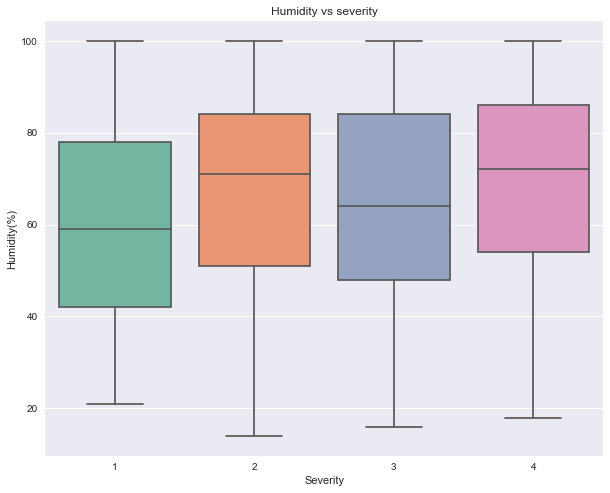

In [45]:
sns.boxplot(x="Severity", y="Humidity(%)", data=Tn_accident1, palette="Set2");
plt.title('Humidity vs severity');

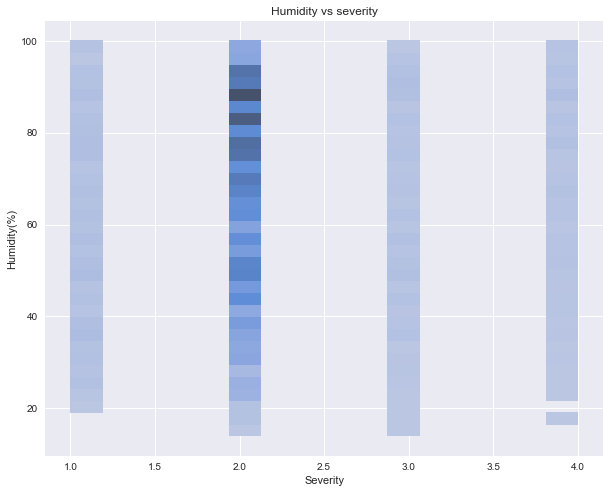

In [46]:
sns.histplot(x="Severity", y="Humidity(%)", data=Tn_accident1, palette="Set3");
plt.title('Humidity vs severity');


In [47]:
#Count of Severity by day and night

pd.crosstab(Tn_accident1["Severity"], Tn_accident1["Sunrise_Sunset"], 
            rownames=['Severity'], colnames=['Sunrise_Sunset'])

Sunrise_Sunset,Day,Night
Severity,,
1,1358,82
2,6577,6677
3,768,207
4,440,335


The barplot below indicates that more severe accidents are happening during the day then in the night time.

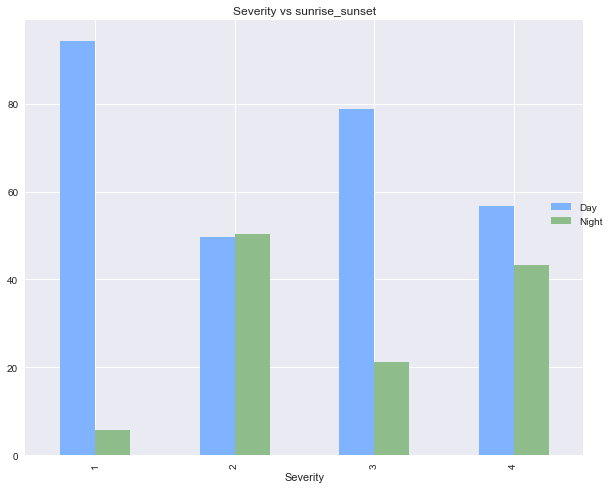

In [48]:
Tn_accident1.groupby(["Severity","Sunrise_Sunset"]).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',color=['#80B3FF', '#8FBC8B'], stacked=False)
plt.title('Severity vs sunrise_sunset')
plt.gca().yaxis
plt.legend(loc = 'upper right',title = 'Sunrise/Sunset')
plt.legend(["Day","Night"],
           bbox_to_anchor = (1.05, 0.6))
plt.show()

#Following plot shows for each variable break down by accident severity, the count of True and False.

From the plot, Corssing, Junction, Tracffic Signal have some impact.

In [49]:
#To plot the variables in the same grid, we used melt() and then groupby() to reshape the dataset.

accident_melt = pd.melt(Tn_accident1,id_vars =['Severity'],value_vars=['Amenity', 'Bump','Crossing','Give_Way',
                         'Junction','No_Exit','Railway','Roundabout','Station',
                         'Stop','Traffic_Calming','Traffic_Signal','Turning_Loop'])
road_gdp = accident_melt.groupby(["Severity","variable","value"]).agg(Count = ('value','count')).reset_index()
road_gdp.head()

,Severity,variable,value,Count
0,1,Amenity,False,1399
1,1,Amenity,True,41
2,1,Bump,False,1440
3,1,Crossing,False,1146
4,1,Crossing,True,294


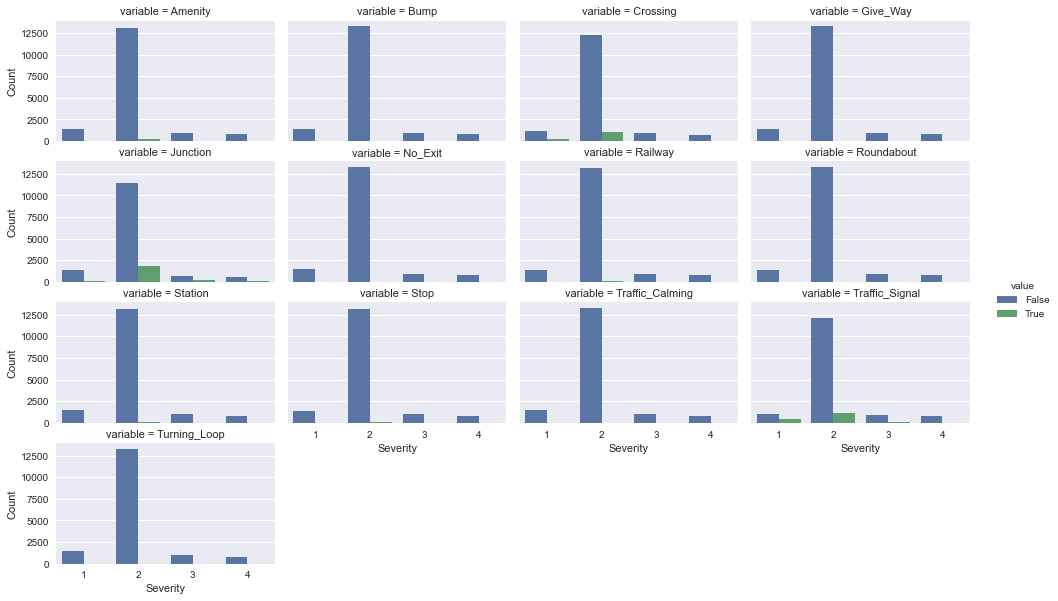

In [50]:

M =sns.catplot(x="Severity", y="Count",
            hue="value", col="variable",
            col_wrap=4, data=road_gdp, kind="bar", height=4, aspect=.7)

M.fig.set_figwidth(15)
M.fig.set_figheight(8)
               

                   

               

In [51]:
severity4=Tn_accident1[Tn_accident1['Severity']==4]
severity4.columns


Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'Description', 'Street', 'Side', 'City', 'County',
       'Zipcode', 'Timezone', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
       'Start_Date', 'End_Date', 'Time_Diff', 'Year', 'Month', 'Day', 'Hour',
       'Min'],
      dtype='object')

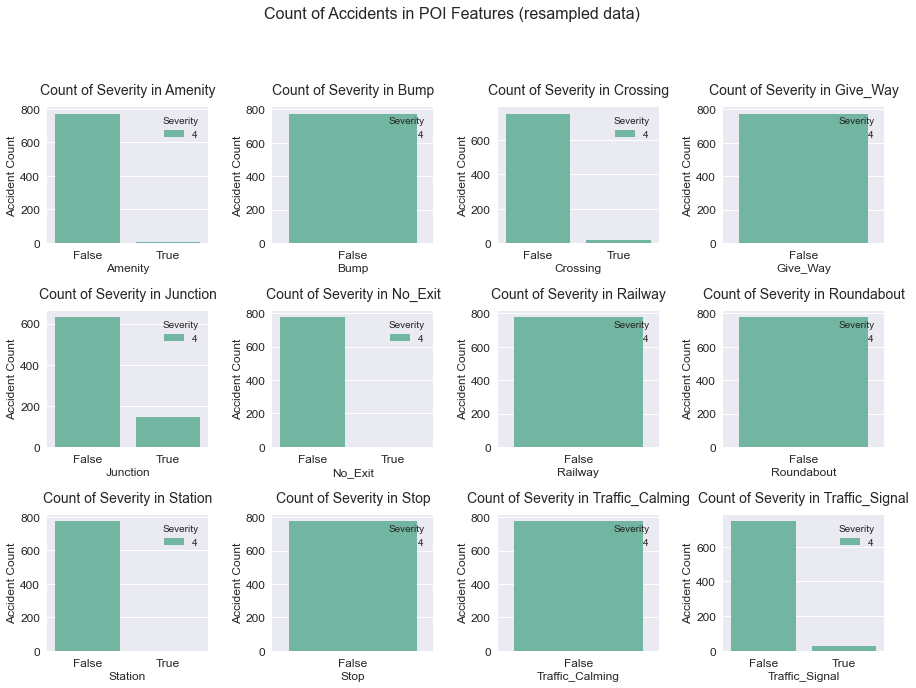

In [52]:
POI_features = ['Amenity','Bump','Crossing','Give_Way','Junction','No_Exit','Railway','Roundabout','Station','Stop','Traffic_Calming','Traffic_Signal']

fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(15, 10))

plt.subplots_adjust(hspace=0.5,wspace = 0.4)
for i, feature in enumerate(POI_features, 1):    
    plt.subplot(3, 4, i)
    sns.countplot(x=feature, hue='Severity', data=severity4,palette="Set2")
    
    plt.xlabel('{}'.format(feature), size=12, labelpad=3)
    plt.ylabel('Accident Count', size=12, labelpad=3)    
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    
    plt.title('Count of Severity in {}'.format(feature), size=14, y=1.05)
fig.suptitle('Count of Accidents in POI Features (resampled data)',y=1.02, fontsize=16)
plt.show()

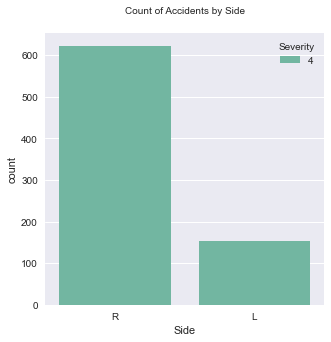

In [53]:
#Side
#Right side of the line is much more dangerous than left side.

plt.figure(figsize=(5,5))
chart = sns.countplot(x='Side',  hue='Severity', data=severity4 ,palette="Set2")
plt.title("Count of Accidents by Side", size=10, y=1.05)
plt.show()

In [54]:
Tn_accident.columns


Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
       'Distance(mi)', 'Description', 'Street', 'Side', 'City', 'County',
       'Zipcode', 'Timezone', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
       'Start_Date', 'End_Date', 'Time_Diff', 'Year', 'Month', 'Day', 'Hour',
       'Min', 'geometry'],
      dtype='object')

# Correlation

In [57]:
# now i want to get the corrlation for the numerical feature with respect to with the Severity
correlation=numeric_features.corr()
print(correlation['Severity'].sort_values(ascending=False),'\n')

Severity           1.000000
Distance(mi)       0.233189
Pressure(in)       0.182180
Start_Lng          0.105828
Humidity(%)        0.061234
Hour               0.029789
Month              0.016855
Day               -0.001598
Min               -0.008986
Start_Lat         -0.011796
Wind_Speed(mph)   -0.013484
Visibility(mi)    -0.014844
Temperature(F)    -0.016345
Year              -0.098905
Name: Severity, dtype: float64 



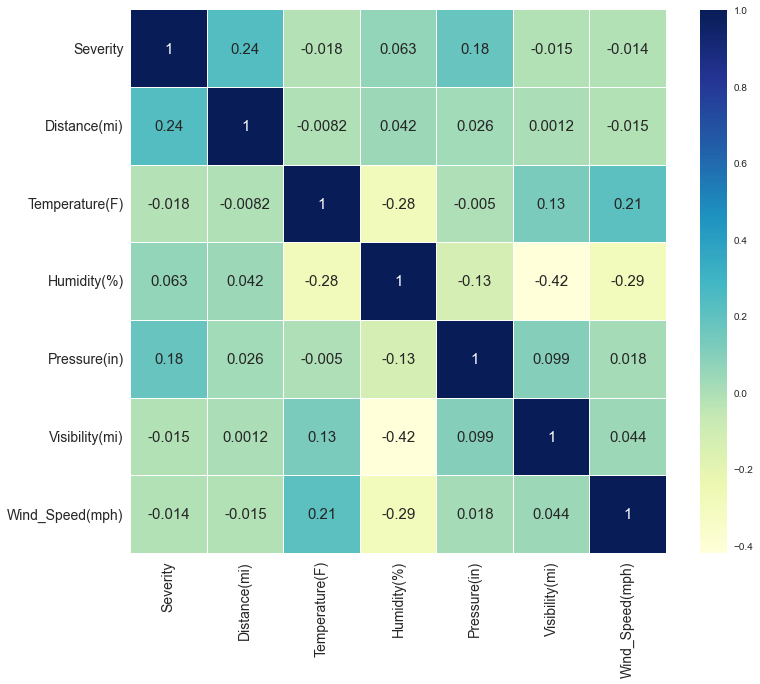

In [58]:
#Finding the correlations in the data

fig=sns.heatmap(Tn_accident1[['Severity',
       'Distance(mi)', 'Description', 'Street', 'Side', 'City', 'County',
       'Zipcode', 'Timezone', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       ]].corr(),annot=True,cmap="YlGnBu",linewidths=0.2 ,annot_kws={'size':15})
fig=plt.gcf()
fig.set_size_inches(12,10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

we want to know for each month, which day of the month are more likely to have more accidents.
From the heatmap below, we can see that more accidents are happening 

Similiarly, we want to see in what time of the day, more accidents will happen using a heatmap.

In [59]:
#weather=Tn_accident1["Weather_Condition"].value_counts().head(10)
#weather.plot(kind='barh', color='#80B3FF')
#plt.gca().invert_yaxis()
#plt.title('Top 10 Accidents per Weather Condition');


In [60]:
#g = sns.catplot(x="Weather_Condition", hue="Severity",
                #data=Tn_accident1, kind="count")
#g.fig.set_size_inches(14,15)
#fig=plt.gcf()

#plt.title('Accidents per Weather Condition Grouped by Severity')
#plt.xticks(
   # rotation=90, 
   # horizontalalignment='right',
   # fontweight='light'
#);

In [61]:
#Rename the columns
Tn_accident1.rename(columns={'Start_Lat':'lat','Start_Lng':'lng'}, inplace=True)
Tn_accident1.head(3)

,ID,Severity,Start_Time,End_Time,lat,lng,Distance(mi),Description,Street,Side,...,Nautical_Twilight,Astronomical_Twilight,Start_Date,End_Date,Time_Diff,Year,Month,Day,Hour,Min
0,A-2749210,2,2016-11-30 05:07:00,2016-11-30 11:07:00,35.152571,-89.886753,0.383,At I-40/Exit 12 - Accident.,I-240 W,R,...,Day,Day,2016-11-30,2016-11-30,0 days 06:00:00,2016,11,30,5,7
1,A-2749215,2,2016-11-30 05:07:00,2016-11-30 11:07:00,35.153122,-89.887304,0.237,At I-240/Sam Cooper/Exit 10/Exit 12 - Accident.,I-40 E,R,...,Day,Day,2016-11-30,2016-11-30,0 days 06:00:00,2016,11,30,5,7
2,A-2749231,2,2016-11-30 05:41:00,2016-11-30 11:41:00,36.153730,-86.763210,0.131,At I-65/Exit 211 - Accident.,I-40 E,R,...,Night,Day,2016-11-30,2016-11-30,0 days 06:00:00,2016,11,30,5,41


In [62]:
country

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."
2,40,01102857,0400000US40,40,OK,Oklahoma,00,177662925723,3374587997,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,51,01779803,0400000US51,51,VA,Virginia,00,102257717110,8528531774,"MULTIPOLYGON (((-75.74241 37.80835, -75.74151 ..."
4,54,01779805,0400000US54,54,WV,West Virginia,00,62266474513,489028543,"POLYGON ((-82.64320 38.16909, -82.64300 38.169..."
5,22,01629543,0400000US22,22,LA,Louisiana,00,111897594374,23753621895,"MULTIPOLYGON (((-88.86770 29.86155, -88.86566 ..."
6,26,01779789,0400000US26,26,MI,Michigan,00,146600952990,103885855702,"MULTIPOLYGON (((-83.19159 42.03537, -83.18993 ..."
7,25,00606926,0400000US25,25,MA,Massachusetts,00,20205125364,7129925486,"MULTIPOLYGON (((-70.23405 41.28565, -70.22361 ..."
8,16,01779783,0400000US16,16,ID,Idaho,00,214049787659,2391722557,"POLYGON ((-117.24267 44.39655, -117.23484 44.3..."
9,12,00294478,0400000US12,12,FL,Florida,00,138949136250,31361101223,"MULTIPOLYGON (((-80.17628 25.52505, -80.17395 ..."


In [63]:
#plt.scatter(Tn_accident1['lng'], Tn_accident1['lat'], c='darkgreen', marker='p')



In [64]:
#create a geometry column that is a Point datatype
Tn_accident1['geometry'] =Tn_accident1.apply(lambda x: Point((float(x.lng), 
                                                         float(x.lat))),
                                        axis=1)

                             
Tn_accident1.head(3)            

,ID,Severity,Start_Time,End_Time,lat,lng,Distance(mi),Description,Street,Side,...,Astronomical_Twilight,Start_Date,End_Date,Time_Diff,Year,Month,Day,Hour,Min,geometry
0,A-2749210,2,2016-11-30 05:07:00,2016-11-30 11:07:00,35.152571,-89.886753,0.383,At I-40/Exit 12 - Accident.,I-240 W,R,...,Day,2016-11-30,2016-11-30,0 days 06:00:00,2016,11,30,5,7,POINT (-89.886753 35.152571)
1,A-2749215,2,2016-11-30 05:07:00,2016-11-30 11:07:00,35.153122,-89.887304,0.237,At I-240/Sam Cooper/Exit 10/Exit 12 - Accident.,I-40 E,R,...,Day,2016-11-30,2016-11-30,0 days 06:00:00,2016,11,30,5,7,POINT (-89.887304 35.153122)
2,A-2749231,2,2016-11-30 05:41:00,2016-11-30 11:41:00,36.153730,-86.763210,0.131,At I-65/Exit 211 - Accident.,I-40 E,R,...,Day,2016-11-30,2016-11-30,0 days 06:00:00,2016,11,30,5,41,POINT (-86.76321 36.15373)


In [65]:
Tn_accident_zip = gpd.GeoDataFrame(Tn_accident1, 
                           crs = zipcodes.crs, 
                           geometry =Tn_accident1['geometry'])

In [66]:
Tn_accident_zip.columns

Index(['ID', 'Severity', 'Start_Time', 'End_Time', 'lat', 'lng',
       'Distance(mi)', 'Description', 'Street', 'Side', 'City', 'County',
       'Zipcode', 'Timezone', 'Airport_Code', 'Temperature(F)', 'Humidity(%)',
       'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
       'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
       'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset',
       'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight',
       'Start_Date', 'End_Date', 'Time_Diff', 'Year', 'Month', 'Day', 'Hour',
       'Min', 'geometry'],
      dtype='object')

In [67]:
type(Tn_accident_zip)

geopandas.geodataframe.GeoDataFrame

In [68]:
zipcodes = zipcodes[['zip', 'po_name', 'geometry']]
zipcodes.head()
    

,zip,po_name,geometry
0,37115,MADISON,"MULTIPOLYGON (((-86.68725 36.31821, -86.68722 ..."
1,37216,NASHVILLE,"MULTIPOLYGON (((-86.73451 36.23774, -86.73425 ..."
2,37204,NASHVILLE,"MULTIPOLYGON (((-86.77914 36.13424, -86.77923 ..."
3,37027,BRENTWOOD,"MULTIPOLYGON (((-86.81258 36.06319, -86.81263 ..."
4,37064,FRANKLIN,"MULTIPOLYGON (((-87.02197 36.01200, -87.02140 ..."


In [69]:
accident_by_zip = gpd.sjoin(Tn_accident_zip,zipcodes, op = 'within')

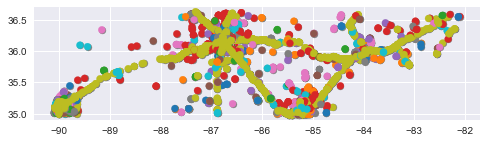

In [70]:
#fig, ax = matplotlib.subplots()
ax = Tn_accident_zip.plot(figsize = (8, 10), color = 'gray')
Tn_accident_zip.plot( ax = ax, column = 'Street');
plt.show();

In [71]:
Tn_accident_zip.geometry.centroid

0        POINT (-89.88675 35.15257)
1        POINT (-89.88730 35.15312)
2        POINT (-86.76321 36.15373)
3        POINT (-86.76102 36.15443)
4        POINT (-86.75153 36.15152)
                    ...            
17138    POINT (-86.83800 36.15409)
17139    POINT (-86.78382 36.14946)
17140    POINT (-86.69323 36.07521)
17141    POINT (-86.88649 35.82332)
17142    POINT (-86.88505 35.82529)
Length: 16444, dtype: geometry

In [72]:
country.head(2)

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
0,28,01779790,0400000US28,28,MS,Mississippi,00,121533519481,3926919758,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,37,01027616,0400000US37,37,NC,North Carolina,00,125923656064,13466071395,"MULTIPOLYGON (((-75.72681 35.93584, -75.71827 ..."


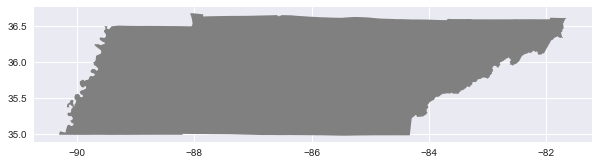

In [73]:
TN=country[country["NAME"] == "Tennessee"].plot(color="gray")

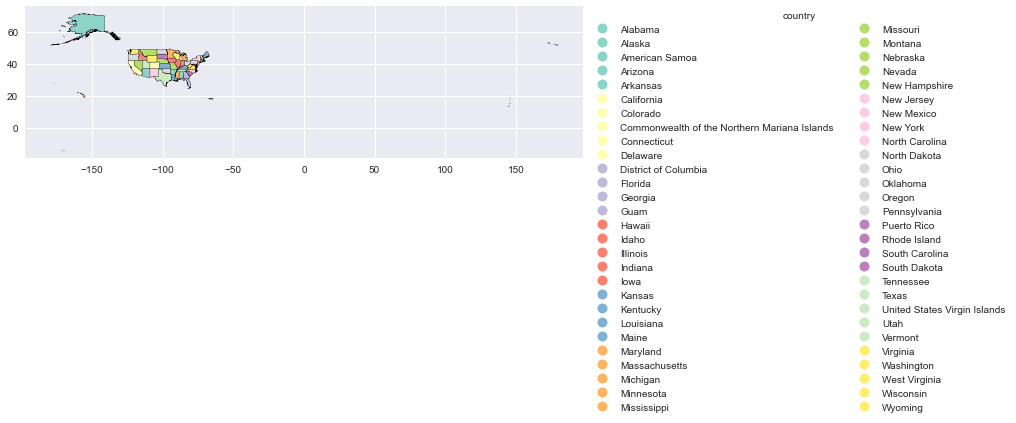

In [74]:
leg_kwds = {'title': 'country', 'loc': 'upper left', 
            'bbox_to_anchor': (1, 1.03), 'ncol': 2}

country.plot(column = 'NAME', figsize=(10, 10),
              edgecolor = 'black',
              legend = True, legend_kwds = leg_kwds, 
              cmap = 'Set3')
plt.show()

<Figure size 1008x576 with 0 Axes>

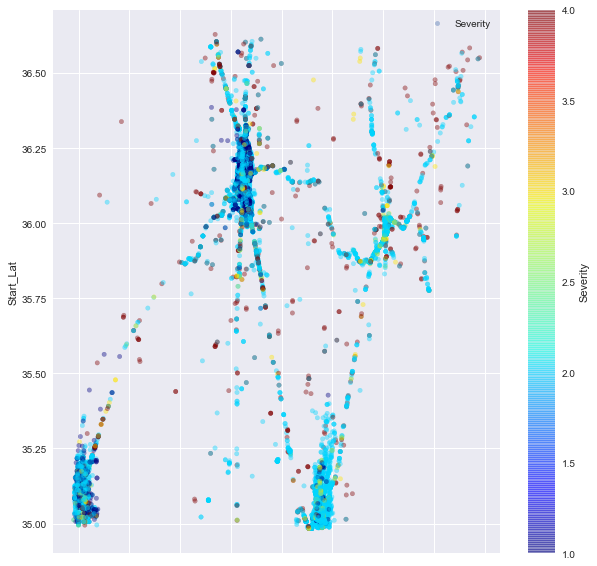

In [75]:
plt.figure(figsize=(14,8))
sub_6=Tn_accident[Tn_accident.Severity<5]
viz_4=sub_6.plot(kind='scatter', x='Start_Lng',y='Start_Lat',label='Severity',c='Severity',cmap=plt.get_cmap('jet'),colorbar=True,alpha=0.4,figsize=(10,10))
viz_4.legend()
plt.ioff()

In [76]:
traffic_accident.head()

,city,rpa,Zipcode,state,weather_description,harmfuldescriptions,number_of_injuries,collision_type,date_and_time,harmfulcodes,...,illuaccidemination,accident_number,collision_type_description,illumination_description,street_address,number_of_fatalities,weather,property_damage,lat,geometry
0,MADISON,17040,37115,TN,CLEAR,MOTOR VEHICLE IN TRANSPORT,0.0000,5,2014-07-06T12:45:00,12,...,1,20400639785,SIDESWIPE - SAME DIRECTION,DAYLIGHT,MM 93 0 I65 N,0.0000,21,None,0.0000,POINT (0.00000 0.00000)
1,NASHVILLE,82042,37210,TN,None,MOTOR VEHICLE IN TRANSPORT,0,4,2021-12-08T22:00:00,12,...,3,20210625398,ANGLE,DARK - LIGHTED,MM 211 7 I 40,0,None,None,36.1499,POINT (-86.74830 36.14990)
2,NASHVILLE,6115,37215,TN,CLEAR,MOTOR VEHICLE IN TRANSPORT,0,11,2021-12-08T17:11:00,12,...,1,20210625322,Front to Rear,DAYLIGHT,HARDING PL & HILLSBORO PKE,0,21,None,36.0914,POINT (-86.82870 36.09140)
3,NASHVILLE,1007,37213,TN,CLEAR,MOTOR VEHICLE IN TRANSPORT,0,5,2021-12-08T18:12:00,12,...,3,20210625225,SIDESWIPE - SAME DIRECTION,DARK - LIGHTED,I24 E ENT RAMP & I 24,0,21,None,36.1662,POINT (-86.76590 36.16620)
4,NASHVILLE,82061,37210,TN,CLEAR,MOTOR VEHICLE IN TRANSPORT,0,11,2021-12-08T18:17:00,12,...,2,20210625203,Front to Rear,DARK - NOT LIGHTED,I24E & I24 W ENT RAMP,0,21,None,36.1386,POINT (-86.72730 36.13860)


In [77]:
#ax = T.plot(figsize = (8, 10), color = 'lightgreen')
#Tn_accident_zip.plot(ax = ax, column = 'City');
#plt.show();

In [78]:
center = 36.174465, -86.767960
print(center)

(36.174465, -86.76796)


In [79]:
#create our map of Nashville Zip Code 37207 and show it
map = folium.Map(location = center, zoom_start = 12,tiles='CartoDB dark_matter')
map

In [80]:
cluster_map = folium.Map(location = center, zoom_start = 4.4,tiles='CartoDB dark_matter')

#create a marker cluster
marker_cluster = MarkerCluster().add_to(cluster_map)

folium.GeoJson(country).add_to(cluster_map)

# inside the loop add each marker to the cluster
for row_index, row_values in .iterrows():
    loc = [row_values['lat'], row_values['lng']]
    pop = str(row_values['ID'])
    icon=folium.Icon(color='gray',icon='car', prefix='fa')
    
    marker = folium.Marker(
        location = loc, 
        popup = pop,
    icon = icon) 
    
    marker.add_to(marker_cluster)
    
    
#save an interactive HTML map by calling .save()
#Tn_accident_zip.save('../maps/cluster37207.html')

cluster_map

SyntaxError: invalid syntax (Temp/ipykernel_24200/300916454.py, line 9)

In [ ]:
Tn_accident1.head(2)

In [ ]:
type(Tn_accident_zip)

In [ ]:
group_city = Tn_accident_zip.groupby(["City"]).agg(Count = ('ID','count'))
group_city.reset_index(level=0, inplace=True)
group_city=group_city.sort_values(by='Count', ascending=False).head(15)
group_city


In [ ]:
city_merge=group_city.merge(Tn_accident_zip, on='City',how='outer')
         
city_merge

In [ ]:
tennessee.crs

In [ ]:
city_merge_geo=gpd.GeoDataFrame(city_merge, 
                           crs = zipcodes.crs, 
                           geometry =Tn_accident_zip['geometry'])

In [ ]:
city_merge_geo.head()

In [ ]:
city_geo=city_merge_geo[['City','Count','geometry']]
type(city_geo)